### **Gerekli Kütüphaneler**
Bu hücrede, veri toplama, işleme, model oluşturma ve değerlendirme gibi projede ihtiyaç duyulan temel işlemler için gerekli kütüphaneler import edilmiştir.

---

#### **Standart Python Kütüphaneleri:**
- **os, time, warnings:** Dosya işlemleri, zaman ölçümü ve uyarı yönetimi için kullanılır.
- **StringIO:** Metin tabanlı verilerin hafızada geçici tutulmasını sağlar.

---

#### **Üçüncü Taraf Kütüphaneler:**
- **numpy, pandas:** Sayısal işlemler ve veri çerçeveleri üzerinde veri analizi yapılır.
- **matplotlib, seaborn:** Veri görselleştirme ve istatistiksel grafikler için kullanılır.
- **requests, yfinance, BeautifulSoup:** Web üzerinden veri çekme ve hisse senedi verilerini toplama işlemlerini gerçekleştirir.

---

#### **scikit-learn Kütüphanesi:**
Makine öğrenimi modelleri oluşturma, hiperparametre optimizasyonu ve veri ön işleme görevleri için kullanılır.  

---

#### **tsfresh Kütüphanesi:**
Zaman serisi verilerinden otomatik öznitelik çıkarımı yapar.  

---

#### **Ek Ayarlar:**
- **set_config(display='diagram'):** Scikit-learn pipeline’larını görsel olarak gösterir.  
- **warnings.filterwarnings("ignore"):** Gereksiz uyarıları kapatır.


In [4]:
import os
import time
import warnings
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import yfinance as yf
from bs4 import BeautifulSoup

from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tsfresh
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters

set_config(display='diagram')

warnings.filterwarnings("ignore")

### **Web Scraping ile Sektör ve Endüstri Verilerini Çekme**

Bu hücrede, hisse senetlerinin sektör ve endüstri bilgilerini toplamak için web scraping işlemleri gerçekleştirilmiştir.  
- **`fetch_sectors_names()`**: Hisse senetlerinin yer aldığı sektörlerin isimlerini çeker.  
- **`fetch_industry_names()`**: Endüstrilere ait isimleri toplar.  
- **`fetch_data(sectors)`**: Belirli bir sektöre ait hisse senedi listesini ve temel bilgilerini getirir.  
Bu işlemler, web sayfalarından veri çekmek için `requests` ve HTML içeriği işlemek için `BeautifulSoup` kütüphanelerini kullanır.  


In [2]:
def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df


sectors=fetch_sectors_names()
sectors

,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1275,11.98T,0.17%,15.97,19.85%,-0.58%,34.92%
1,Healthcare,1158,"8,029.15B",0.50%,61.45,3.08%,-0.20%,9.45%
2,Technology,768,21.81T,0.49%,46.46,14.60%,1.47%,43.51%
3,Industrials,666,"5,954.30B",1.18%,29.56,7.25%,0.79%,25.50%
4,Consumer Discretionary,561,"8,844.74B",0.77%,29.56,6.53%,0.79%,34.98%
5,Materials,265,"2,040.43B",1.71%,27.70,6.33%,1.01%,14.79%
6,Real Estate,262,"1,674.90B",3.83%,49.23,9.53%,0.07%,13.01%
7,Energy,251,"3,671.71B",3.11%,13.57,8.12%,1.89%,14.53%
8,Communication Services,248,"6,885.43B",1.40%,30.44,11.75%,0.64%,38.03%
9,Consumer Staples,243,"4,260.18B",1.52%,29.91,4.89%,0.76%,28.22%


### **Web Scraping ile Sektörel Verilerin CSV Dosyalarına Kaydedilmesi**

Bu hücrede, `fetch_data()` fonksiyonu kullanılarak farklı sektörlere ait hisse senedi verileri webden çekilmiş ve CSV dosyalarına kaydedilmiştir.  
- Her sektör için ayrı bir CSV dosyası oluşturulmuş ve belirtilen dizine kaydedilmiştir.  
- Bu adım, daha sonraki veri işleme ve analiz aşamalarında kullanılacak ham veriyi sağlar.


In [ ]:
fetch_data(sectors='energy').to_csv(r'C:\Users\acer\Desktop\yzup\data\energy.csv')
fetch_data(sectors='financials').to_csv(r'C:\Users\acer\Desktop\yzup\data\financials.csv')
fetch_data(sectors='healthcare').to_csv(r'C:\Users\acer\Desktop\yzup\data\healthcare.csv')
fetch_data(sectors='technology').to_csv(r'C:\Users\acer\Desktop\yzup\data\technology.csv')
fetch_data(sectors='utilities').to_csv(r'C:\Users\acer\Desktop\yzup\data\utilities.csv')
fetch_data(sectors='real-estate').to_csv(r'C:\Users\acer\Desktop\yzup\data\real-estate.csv')
fetch_data(sectors='materials').to_csv(r'C:\Users\acer\Desktop\yzup\data\materials.csv')
fetch_data(sectors='industrials').to_csv(r'C:\Users\acer\Desktop\yzup\data\industrials.csv')
fetch_data(sectors='consumer-staples').to_csv(r'C:\Users\acer\Desktop\yzup\data\consumer-staples.csv')
fetch_data(sectors='consumer-discretionary').to_csv(r'C:\Users\acer\Desktop\yzup\data\consumer-discretionary.csv')
fetch_data(sectors='communication-services').to_csv(r'C:\Users\acer\Desktop\yzup\data\communication-services.csv')

### **Sektör Verilerinin Toplanması ve Aylık Getirilerin Kaydedilmesi**

Bu hücrede, her sektördeki şirketlerin hisse senedi verileri `Yahoo Finance` üzerinden toplanır, aylık getiriler hesaplanır ve ilgili CSV dosyalarına kaydedilir.

#### **İşlem Adımları:**

1. **Sektör ve Dosya Yolu Eşlemesi:**  
   - `sectors_and_files` değişkeni kullanılarak her sektörün ilgili şirket listesini içeren CSV dosyalarının yolları belirlenir.

2. **Veri Çekme Fonksiyonu (`getir_kaydet`):**  
   - `input_csv`: Hisse senetlerinin sembollerini içeren girdi dosyası.  
   - `output_csv`: Aylık getirilerin kaydedileceği çıktı dosyası.  
   - `sector_label`: Her sektörün etiket bilgisi (örn. `financials`, `healthcare`).  

3. **Aylık Verilerin Toplanması:**  
   - Her sektör için ilk 500 sembol seçilir.  
   - `yf.download` ile her sembol için 2005-01-01’den itibaren aylık kapanış fiyatları çekilir.  
   - Kapanış fiyatı üzerinden yüzdelik değişim hesaplanarak aylık getiri (`Monthly Return`) hesaplanır.

4. **Verilerin Kaydedilmesi:**  
   - Toplanan veriler her sektör için ayrı bir CSV dosyasına (`_aylik_donus.csv`) kaydedilir.

5. **API Sınırını Aşmamak İçin Bekleme:**  
   - Hisse başına veri çekme işlemi sonrasında 0.5 saniye bekleme süresi eklenmiştir.

#### **Örnek Çıktılar:**  
Her sektör için veriler `financials_aylik_donus.csv`, `healthcare_aylik_donus.csv` gibi dosyalarda saklanır. Bu dosyalar sonraki adımlarda verinin işlenmesi ve model eğitimi için kullanılacaktır.

#### **Amaç:**  
Farklı sektörlerdeki hisse senetlerinin aylık bazda getirilerini hesaplayarak veri setini oluşturmak ve sonraki analizlerde kullanılmak üzere kaydetmektir.


In [ ]:
# Sektör ve dosya yollarını eşleştirelim
sectors_and_files = {
    'financials': r'C:\Users\acer\Desktop\yzup\data\financials.csv',
    'healthcare': r'C:\Users\acer\Desktop\yzup\data\healthcare.csv',
    'technology': r'C:\Users\acer\Desktop\yzup\data\technology.csv'
}

def getir_kaydet(input_csv, output_csv, sector_label):
    # CSV dosyasından sembol listesini oku
    symbols_df = pd.read_csv(input_csv)
    # İlk 500 sembolü seç (eğer varsa)
    symbols = symbols_df['Symbol'].tolist()[:500]
    all_returns = []

    for symbol in symbols:
        print(f"Fetching data for {symbol}")
        try:
            # 2005-01-01'den itibaren aylık verileri çek
            stock_data = yf.download(symbol, start="2005-01-01", interval='1mo')
            
            if stock_data.empty:
                print(f"No data found for {symbol}. Skipping...")
                continue

            # Sadece 'Close' sütununu kullan
            if 'Close' in stock_data.columns:
                stock_data['Price'] = stock_data['Close']
            else:
                print(f"No suitable price column found for {symbol}. Skipping...")
                continue

            # Aylık getiri hesapla (bir önceki ayın kapanışına göre yüzdelik değişim)
            stock_data['Monthly Return'] = stock_data['Price'].pct_change()
            stock_data['Symbol'] = symbol
            stock_data['Sector'] = sector_label  # Sektör bilgisini ekle
            stock_data.reset_index(inplace=True)
            all_returns.append(stock_data[['Date', 'Symbol', 'Sector', 'Price', 'Monthly Return']])

        except Exception as e:
            print(f"Failed to fetch data for {symbol}: {e}")
        
        # API sınırını aşmamak için bekleme süresi (0.5 saniye)
        time.sleep(0.5)

    # Tüm sembollerden gelen verileri birleştir ve CSV'ye kaydet
    if all_returns:
        result = pd.concat(all_returns)
        result.to_csv(output_csv, index=False)
        print(f"Saved monthly returns to {output_csv}.")
    else:
        print(f"No data fetched for {input_csv}")

# Her sektör için işlemi tekrarla ve sektör etiketini ekle
for sector, input_csv in sectors_and_files.items():
    output_csv = f'C:\\Users\\acer\\Desktop\\yzup\\data\\{sector}_aylik_donus.csv'
    getir_kaydet(input_csv, output_csv, sector_label=sector)

### **Sektörel Aylık Getiri Verilerinin Yüklenmesi**

Bu hücrede, daha önce hesaplanıp CSV dosyalarına kaydedilen sektörlere ait aylık getiri verileri `pandas` kullanılarak veri çerçevelerine (`DataFrame`) yüklenmiştir.

- **Veriler:**  
  - `technology_aylik_donus`: Teknoloji sektörüne ait aylık getiri verileri.  
  - `healthcare_aylik_donus`: Sağlık sektörüne ait aylık getiri verileri.  
  - `financials_aylik_donus`: Finans sektörüne ait aylık getiri verileri.

Bu adımda yüklenen veriler, sonraki veri analizi ve modelleme aşamalarında kullanılacaktır.


In [2]:
technology_aylik_donus = pd.read_csv(r'C:\Users\acer\Desktop\yzup\data\technology_aylik_donus.csv')
healthcare_aylik_donus = pd.read_csv(r'C:\Users\acer\Desktop\yzup\data\healthcare_aylik_donus.csv')
financials_aylik_donus = pd.read_csv(r'C:\Users\acer\Desktop\yzup\data\financials_aylik_donus.csv')

financials_aylik_donus

,Date,Symbol,Sector,Price,Monthly Return
0,NaN,NaN,NaN,NaN,NaN
1,2005-01-01,JPM,financials,21.668661,NaN
2,2005-02-01,JPM,financials,21.401770,-0.012317
3,2005-03-01,JPM,financials,20.259951,-0.053352
4,2005-04-01,JPM,financials,20.781086,0.025722
...,...,...,...,...,...
91592,2024-10-01,ANSC,financials,10.385000,0.003382
91593,2024-11-01,ANSC,financials,10.420000,0.003370
91594,2024-12-01,ANSC,financials,10.490000,0.006718
91595,2025-01-01,ANSC,financials,10.520000,0.002860


### **Custom Transformer - Veri Okuma ve Temizleme**

Bu hücrede, `scikit-learn`'in `BaseEstimator` ve `TransformerMixin` sınıflarını miras alan `DataLoaderCleaner` adlı özel bir veri dönüştürücü tanımlanmıştır. Bu dönüştürücü, CSV dosyalarından verileri okuyup temizleyerek modelleme aşamasında kullanılabilir hale getirir.

#### **İşlem Adımları:**
- **Dosyaların Okunması:** Her sektöre ait CSV dosyası okunur ve tarih bilgisi parse edilir.
- **Boş Değerlerin Temizlenmesi:** Boş `Date` ve `Symbol` sütunları silinir.
- **Sektör Etiketinin Eklenmesi:** Her veri çerçevesine ait sektör etiketi (`Sector`) eklenir.
- **Eksik Değerlerin Doldurulması:** Sayısal sütunlarda eksik veriler sütunların ortalaması ile doldurulur.
- **Log Dönüşümleri:** Fiyat ve aylık getiri verilerine log dönüşümü uygulanır:  
  - **`Log_Price`**: Fiyatın log dönüşümü.  
  - **`Log_Monthly_Return`**: Aylık getirinin log dönüşümü.

#### **Çıktı:**  
Tüm sektörlere ait temizlenmiş, eksik verileri doldurulmuş ve dönüşümleri yapılmış birleştirilmiş bir DataFrame.


In [34]:
class DataLoaderCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, sectors_and_files):
        self.sectors_and_files = sectors_and_files

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        combined_df_list = []
        for sector, file_path in self.sectors_and_files.items():
            df = pd.read_csv(file_path, parse_dates=['Date'])
            df = df.drop(index=0)  # 0. satırı sil
            df = df.dropna(subset=['Date', 'Symbol'])  # Boş tarih veya sembol varsa sil
            df['Sector'] = sector  # Sektör bilgisi ekle
            combined_df_list.append(df)
        
        combined_df = pd.concat(combined_df_list, ignore_index=True)
        
        # Eksik değerleri doldur (numeric sütunlarda ortalama ile)
        numeric_cols = combined_df.select_dtypes(include='number').columns
        combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].mean())
        
        # Log dönüşümleri
        combined_df['Log_Price'] = np.log(combined_df['Price'] + 1)
        combined_df['Log_Monthly_Return'] = np.log(combined_df['Monthly Return'] + 1)
        return combined_df

### **Custom Transformer - Label Encoding ve Sütun Seçimi**

Bu hücrede, `LabelEncodingFeatureSelection` adlı özel bir dönüştürücü tanımlanmıştır. Bu sınıf, kategorik verilerin sayısal hale getirilmesi ve gerekli sütunların seçilmesi işlemlerini gerçekleştirir.

#### **İşlem Adımları:**
- **Label Encoding:**  
  - `Sector` sütunu, sektörleri sayısal değerlere dönüştürmek için `LabelEncoder` ile encode edilir ve `Sector_Encoded` sütunu oluşturulur.  
  - `Symbol` sütunu, hisse senedi sembollerini sayısal değerlere dönüştürmek için encode edilir ve `Symbol_Encoded` sütunu oluşturulur.

- **Sütun Seçimi:**  
  - Dönüştürücü, yalnızca model için gerekli olan sütunları seçer ve döner:  
    - `Symbol`  
    - `Date`  
    - `Log_Monthly_Return`  
    - `Log_Price`  
    - `Sector_Encoded`

#### **Amaç:**  
Kategorik değişkenleri sayısal hale getirip, modelleme sürecinde kullanılacak özellikleri içeren sade bir veri çerçevesi oluşturmak.


In [35]:
class LabelEncodingFeatureSelection(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.label_encoder_sector = LabelEncoder().fit(X['Sector'])
        self.label_encoder_symbol = LabelEncoder().fit(X['Symbol'])
        return self

    def transform(self, X):
        X = X.copy()
        X['Sector_Encoded'] = self.label_encoder_sector.transform(X['Sector'])
        X['Symbol_Encoded'] = self.label_encoder_symbol.transform(X['Symbol'])
        # İlgili sütunları seçiyoruz
        return X[['Symbol', 'Date', 'Log_Monthly_Return', 'Log_Price', 'Sector_Encoded']]

### **Custom Transformer - Öznitelik Çıkarımı (tsfresh)**

Bu hücrede, zaman serisi verilerinden otomatik olarak öznitelik çıkarımı yapmak için `TSFreshFeatureExtractor` adlı özel bir dönüştürücü tanımlanmıştır. Bu dönüştürücü, her hisse senedinin zaman serisinden çeşitli istatistiksel özellikleri çıkarır.

#### **İşlem Adımları:**
- **Parametrelerin Ayarlanması:**  
  - `MinimalFCParameters()`: Sınırlı sayıda temel öznitelik çıkarır (örneğin, ortalama, maksimum, varyans).  
  - `n_jobs_value`: Paralel işlem yapılacak çekirdek sayısını belirler.

- **Öznitelik Çıkarımı:**  
  - Zaman serisi verisindeki `Log_Monthly_Return` ve `Log_Price` sütunlarına dayanarak tsfresh ile öznitelikler çıkarılır.  
  - `extract_features()` fonksiyonu, her `Symbol` (hisse senedi) için belirlenen öznitelikleri hesaplar (örneğin, ortalama, otokorelasyon, maksimum değer).

- **Sektör Bilgisinin Eklenmesi:**  
  - Çıkarılan öznitelikler, `Sector_Encoded` sütunuyla birleştirilir ve her hisse senedi için sektör etiketi korunur.

#### **Amaç:**  
Zaman serisi verilerinin ham değerlerinden istatistiksel ve anlamlı özellikler çıkararak modelleme için uygun hale getirmek.


In [39]:
class TSFreshFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_jobs_value):
        self.fc_parameters = MinimalFCParameters()
        self.n_jobs_value = n_jobs_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_filtered = X[['Symbol', 'Date', 'Log_Monthly_Return', 'Log_Price']]
        features = extract_features(
            df_filtered,
            column_id='Symbol',
            column_sort='Date',
            default_fc_parameters=self.fc_parameters,
            n_jobs=self.n_jobs_value
        )
        # Sadece tekil sembol başına gelen 'Sector_Encoded' bilgisini ekliyoruz
        features = features.join(
            X[['Symbol', 'Sector_Encoded']].drop_duplicates().set_index('Symbol')
        )
        return features

### **Custom Transformer - Öznitelik Seçimi (Lasso)**

Bu hücrede, `LassoFeatureSelector` adlı özel bir dönüştürücü tanımlanmıştır. Bu dönüştürücü, zaman serisinden çıkarılan öznitelikler arasından en önemli olanları seçmek için L1 regularization yöntemiyle çalışan Lasso algoritmasını kullanır.

#### **İşlem Adımları:**
- **Hedef Değişkenin Belirlenmesi:**  
  - Eğer dışarıdan bir hedef değişken (`y`) verilmemişse, veri kümesindeki `Sector_Encoded` sütunu hedef olarak alınır.

- **Özniteliklerin Filtrelenmesi:**  
  - Sadece tsfresh ile çıkarılan ve `Log_Monthly_Return__` veya `Log_Price__` ile başlayan öznitelikler seçilir.

- **Ölçeklendirme:**  
  - `StandardScaler` ile veriler ölçeklendirilir ve Lasso regresyonu için uygun hale getirilir.

- **Öznitelik Seçimi:**  
  - `LassoCV` kullanılarak 5 katlı çapraz doğrulama yapılır ve L1 regularization sonucu sıfır olmayan katsayıya sahip özellikler seçilir.

- **Sonuç:**  
  - Seçilen en önemli özniteliklerle birlikte hedef sütun (`Sector_Encoded`) döndürülür.

#### **Amaç:**  
Gereksiz ve anlamlı olmayan öznitelikleri elemek, modelin daha verimli ve genellenebilir olmasını sağlamak.


In [40]:
class LassoFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_features = None

    def fit(self, X, y=None):
        if y is None:
            y = X['Sector_Encoded']
    
        X_filtered = X.filter(regex='^(Log_Monthly_Return|Log_Price)__')
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_filtered)
        
        lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)
        self.selected_features = X_filtered.columns[lasso.coef_ != 0]
        
        return self

    def transform(self, X):
        return X[self.selected_features.tolist() + ['Sector_Encoded']]

### **Pipeline Tanımlama**

Bu hücrede, veri işleme adımlarının otomatik ve sıralı bir şekilde uygulanmasını sağlayan bir **scikit-learn Pipeline** tanımlanmıştır. Bu pipeline, verilerin temizlenmesi, dönüştürülmesi ve öznitelik seçimi gibi adımları ardışık olarak gerçekleştirir.

#### **Pipeline Adımları:**
1. **`DataLoaderCleaner` (Veri Okuma ve Temizleme):**  
   - Sektörlere ait CSV dosyaları okunur, eksik değerler doldurulur ve log dönüşümleri yapılır.

2. **`LabelEncodingFeatureSelection` (Label Encoding ve Sütun Seçimi):**  
   - Sektör ve semboller sayısal değerlere dönüştürülür ve gerekli sütunlar seçilir.

3. **`TSFreshFeatureExtractor` (Öznitelik Çıkarımı):**  
   - Zaman serisi verilerinden tsfresh kullanılarak otomatik öznitelikler çıkarılır.

4. **`LassoFeatureSelector` (Öznitelik Seçimi):**  
   - L1 regularization (Lasso) yöntemiyle en önemli öznitelikler belirlenir ve gereksiz olanlar elenir.

#### **Amaç:**  
Bu pipeline, karmaşık veri işleme adımlarını tek bir yapı altında toplayarak kodun tekrar kullanılabilirliğini ve verimliliğini artırır.


In [41]:
pipeline = Pipeline([
    ('data_loading_cleaning', DataLoaderCleaner(sectors_and_files={
        'financials': r'C:\Users\acer\Desktop\yzup\data\financials_aylik_donus.csv',
        'healthcare': r'C:\Users\acer\Desktop\yzup\data\healthcare_aylik_donus.csv',
        'technology': r'C:\Users\acer\Desktop\yzup\data\technology_aylik_donus.csv'
    })),
    ('label_encoding_feature_selection', LabelEncodingFeatureSelection()),
    ('tsfresh_feature_extraction', TSFreshFeatureExtractor(n_jobs_value=max(1, os.cpu_count() - 1))),
    ('lasso_feature_selection', LassoFeatureSelector())
])

### **Veriyi Pipeline ile İşleme ve Hedef Değişkenini Ayrıştırma**

Bu hücrede, tanımlanan pipeline kullanılarak veriler işlenmiş ve modelleme için kullanılacak özellik matrisi (`X`) ve hedef değişken (`y`) ayrıştırılmıştır.

#### **İşlem Adımları:**
- **Pipeline’ın Çalıştırılması:**  
  - Pipeline, veriyi okuma, temizleme, öznitelik çıkarma ve seçme adımlarını sırasıyla gerçekleştirir.  
  - `fit_transform()` fonksiyonu ile tüm bu işlemler sonucunda işlenmiş veri (`processed_data`) elde edilir.

- **Özellik ve Hedef Ayrımı:**  
  - `X`: İşlenmiş veriden `Sector_Encoded` dışındaki öznitelikleri içerir.  
  - `y`: Her hisse senedine karşılık gelen sektör etiketi (`Sector_Encoded`) hedef değişken olarak ayrıştırılır.

#### **Amaç:**  
İşlenmiş verileri modelleme için uygun formata getirmek ve bağımsız değişkenler (`X`) ile hedef değişkeni (`y`) ayırarak sınıflandırma modelini eğitmeye hazırlamak.


In [42]:
processed_data = pipeline.fit_transform(None, None)
X = processed_data.drop(columns=['Sector_Encoded'])
y = processed_data['Sector_Encoded']

Feature Extraction: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]


### **RandomForest Modeli Eğitimi ve Hiperparametre Optimizasyonu**

Bu hücrede, `RandomForestClassifier` kullanılarak bir sınıflandırma modeli eğitilmiş ve en iyi hiperparametreleri belirlemek için `GridSearchCV` yöntemi uygulanmıştır.

#### **İşlem Adımları:**
- **Hiperparametre Grid’i:**  
  - `n_estimators`: Ağaç sayısı ([100, 200, 300, 500])  
  - `max_depth`: Maksimum derinlik ([10, 20, 30, 50])  
  - `min_samples_split`: Dallanma için gerekli minimum örnek sayısı ([2, 5, 10])  
  - `min_samples_leaf`: Her yaprak düğümdeki minimum örnek sayısı ([1, 2, 5])

- **GridSearchCV:**  
  - Belirlenen hiperparametre kombinasyonlarını dener ve 5 katlı çapraz doğrulama (`cv=5`) ile modelin genelleme performansını değerlendirir.  
  - `accuracy` skoru üzerinden en iyi parametreleri seçer.

- **Modelin Eğitilmesi:**  
  - Tüm parametre kombinasyonları test edildikten sonra en iyi parametreler ile model eğitilir.

#### **Çıktılar:**
- **En iyi hiperparametreler:** Modelin en iyi doğruluğa ulaşmasını sağlayan parametre kombinasyonu.
- **En iyi çapraz doğrulama doğruluğu:** Farklı veri bölümlerinde test edilerek modelin genelleme performansını gösterir.

#### **Amaç:**  
Modelin performansını artırmak ve overfitting (aşırı öğrenme) riskini minimize etmek için en uygun hiperparametre kombinasyonunu seçmek.


In [9]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=max(1, os.cpu_count() - 1)
)

grid_search.fit(X, y)

print("\nEn iyi hiperparametreler:")
print(grid_search.best_params_)
print(f"En iyi modelin cross-validation doğruluğu: {grid_search.best_score_:.4f}")


En iyi hiperparametreler:
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
En iyi modelin cross-validation doğruluğu: 0.6077


### **XGBoost Modeli Eğitimi ve Hiperparametre Optimizasyonu**

Bu hücrede, `XGBoost` sınıflandırma algoritması kullanılarak model eğitilmiş ve `GridSearchCV` ile en iyi hiperparametreler belirlenmiştir.

#### **Çıktılar:**
- **En iyi hiperparametreler:** XGBoost modelinin en iyi performans verdiği parametre kombinasyonu.  
- **En iyi çapraz doğrulama doğruluğu:** Modelin genel veri üzerinde ne kadar başarılı olduğunu gösterir.

#### **Amaç:**  
Modelin doğruluğunu artırarak daha iyi genelleme sağlayan bir XGBoost modeli elde etmek.


In [10]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=5,
    n_jobs=max(1, os.cpu_count() - 1)
)

grid_search_xgb.fit(X, y)

print("\nXGBoost - En iyi hiperparametreler:")
print(grid_search_xgb.best_params_)
print(f"XGBoost - En iyi modelin cross-validation doğruluğu: {grid_search_xgb.best_score_:.4f}")


XGBoost - En iyi hiperparametreler:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost - En iyi modelin cross-validation doğruluğu: 0.5976


### **CatBoost Modeli Eğitimi ve Hiperparametre Optimizasyonu**

Bu hücrede, `CatBoost` sınıflandırma algoritması kullanılarak model eğitilmiş ve `GridSearchCV` ile en iyi hiperparametreler belirlenmiştir.

#### **Çıktılar:**
- **En iyi hiperparametreler:** CatBoost modelinin en iyi performansı gösterdiği parametre kombinasyonu.  
- **En iyi çapraz doğrulama doğruluğu:** Farklı veri bölümlerinde test edilerek modelin genelleme performansını gösterir.

#### **Amaç:**  
CatBoost modelinin doğruluğunu ve genelleme kabiliyetini artırarak sınıflandırma performansını optimize etmek.


In [11]:
from catboost import CatBoostClassifier

param_grid_cat = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.05, 0.01]
}

grid_search_cat = GridSearchCV(
    estimator=CatBoostClassifier(random_state=42, verbose=0),
    param_grid=param_grid_cat,
    scoring='accuracy',
    cv=5,
    n_jobs=max(1, os.cpu_count() - 1)
)

grid_search_cat.fit(X, y)

print("\nCatBoost - En iyi hiperparametreler:")
print(grid_search_cat.best_params_)
print(f"CatBoost - En iyi modelin cross-validation doğruluğu: {grid_search_cat.best_score_:.4f}")


CatBoost - En iyi hiperparametreler:
{'depth': 8, 'iterations': 300, 'learning_rate': 0.05}
CatBoost - En iyi modelin cross-validation doğruluğu: 0.6076


### **Pipeline Görselleştirmesi**

In [12]:
pipeline

Pipeline(steps=[('data_loading_cleaning',
                 DataLoaderCleaner(sectors_and_files={'financials': 'C:\\Users\\acer\\Desktop\\yzup\\data\\financials_aylik_donus.csv',
                                                      'healthcare': 'C:\\Users\\acer\\Desktop\\yzup\\data\\healthcare_aylik_donus.csv',
                                                      'technology': 'C:\\Users\\acer\\Desktop\\yzup\\data\\technology_aylik_donus.csv'})),
                ('label_encoding_feature_selection',
                 LabelEncodingFeatureSelection()),
                ('tsfresh_feature_extraction',
                 TSFreshFeatureExtractor(n_jobs_value=7)),
                ('lasso_feature_selection', LassoFeatureSelector())])

### **Eğitim ve Test Verisi Üzerinde Model Değerlendirmesi**

Bu hücrede, modeli değerlendirmek için veri eğitim ve test setlerine ayrılmış ve modelin doğruluk, F1 skoru ve ROC-AUC değerleri hesaplanmıştır.

#### **İşlem Adımları:**

1. **Veri Setinin Ayrılması:**  
   - `train_test_split` kullanılarak veri seti %80 eğitim ve %20 test olarak ayrılır.  
   - `stratify=y` parametresi, eğitim ve test setlerinde hedef değişkenin sınıf dağılımının korunmasını sağlar.

2. **Modelin Eğitilmesi:**  
   - Eğitim verisi üzerinde `grid_search` ile en iyi hiperparametre kombinasyonları kullanılarak model eğitilir.

3. **Tahmin:**  
   - Eğitimden sonra model, test verisi üzerinde tahminler yapar (`y_pred`).  

4. **Değerlendirme Metrikleri:**  
   - **Accuracy:** Test setindeki tahminlerin genel doğruluk oranını ölçer.  
   - **F1 Score:** Dengeli sınıflar arasında doğruluk ve geri çağırma (recall) metriklerinin harmonik ortalamasını verir.  
   - **ROC-AUC:** Çok sınıflı sınıflandırmada `one-vs-rest` stratejisiyle tahmin edilen olasılıkların ayrım gücünü ölçer.

#### **Çıktılar:**
- **Accuracy:** Modelin doğru tahmin ettiği veri oranı.  
- **F1 Score:** Sınıflar arasındaki genel dengeyi değerlendiren metrik.  
- **ROC-AUC:** Sınıfların birbirinden ne kadar iyi ayrıldığını gösterir.

#### **Amaç:**  
Modelin eğitim sırasında öğrendiği bilgileri test verisi üzerinde ne kadar başarılı şekilde genelleyebildiğini değerlendirmek.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

acc = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test), multi_class='ovr')

print("Test Accuracy: {:.4f}".format(acc))
print("Test F1 Score: {:.4f}".format(f1))
print("Test ROC-AUC: {:.4f}".format(roc_auc))

Test Accuracy: 0.5987
Test F1 Score: 0.5977
Test ROC-AUC: 0.7856


### **Confusion Matrix ve Sınıflandırma Raporu**

Bu hücrede, modelin test setindeki performansını detaylı şekilde değerlendirmek için Confusion Matrix ve sınıflandırma raporu oluşturulmuştur.

#### **İşlem Adımları:**

1. **Confusion Matrix Hesaplama:**  
   - `confusion_matrix` fonksiyonu ile gerçek sınıflar ve tahmin edilen sınıflar arasındaki doğruluk değerlendirilir.  
   - Her bir sınıf için doğru ve yanlış tahmin edilen örneklerin sayısını gösterir.

2. **Görselleştirme:**  
   - `seaborn` kütüphanesi ile Confusion Matrix, renkli bir ısı haritası olarak görselleştirilir.  
   - X ekseni tahmin edilen değerleri, Y ekseni ise gerçek değerleri temsil eder.

3. **Sınıflandırma Raporu:**  
   - `classification_report` ile her bir sınıf için precision (kesinlik), recall (geri çağırma) ve F1 skorları hesaplanır.  
   - Ayrıca tüm sınıflar için makro (macro) ve ağırlıklı (weighted) ortalamalar da sunulur.

#### **Amaç:**  
Confusion Matrix ve sınıflandırma raporu, modelin hangi sınıflarda iyi performans gösterdiğini ve hangi sınıflarda iyileştirme gerektiğini anlamak için kullanılır.


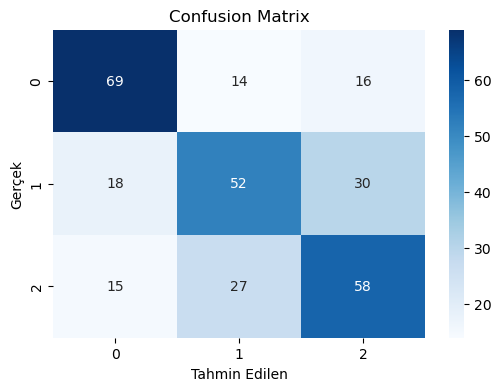

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        99
           1       0.56      0.52      0.54       100
           2       0.56      0.58      0.57       100

    accuracy                           0.60       299
   macro avg       0.60      0.60      0.60       299
weighted avg       0.60      0.60      0.60       299



In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

### **ROC Eğrileri ve AUC Değerlendirmesi**

Bu hücrede, her sınıf için ROC eğrileri (Receiver Operating Characteristic) çizdirilmiş ve her sınıfa ait AUC (Area Under the Curve) değerleri hesaplanmıştır.

#### **İşlem Adımları:**

1. **Sınıf Sayısının Belirlenmesi:**  
   - `y_test` üzerindeki benzersiz sınıf sayısı belirlenir (`n_classes`), her bir sınıf için ROC eğrisi ayrı ayrı çizilecektir.

2. **Tahmin Olasılıklarının Alınması:**  
   - `grid_search.predict_proba()` fonksiyonu ile her sınıf için tahmin edilen olasılıklar alınır (`y_score`).

3. **ROC Eğrisi Hesaplama:**  
   - Her sınıf için `roc_curve` kullanılarak yanlış pozitif oran (`fpr`) ve doğru pozitif oran (`tpr`) hesaplanır.  
   - Her sınıfın AUC değeri (`auc`) hesaplanır.

4. **Görselleştirme:**  
   - Her sınıf için ROC eğrisi çizilir ve AUC değerleri grafikte gösterilir.  
   - [0, 1] doğrusu, rastgele bir sınıflandırmayı temsil eder ve model performansını bu doğruyla kıyaslamak için kullanılır.

#### **Amaç:**  
ROC eğrileri ve AUC değerleri, modelin sınıflar arasındaki ayrım gücünü ölçer. AUC değeri 1’e ne kadar yakınsa modelin o sınıfı doğru ayırt etme yeteneği o kadar yüksektir.


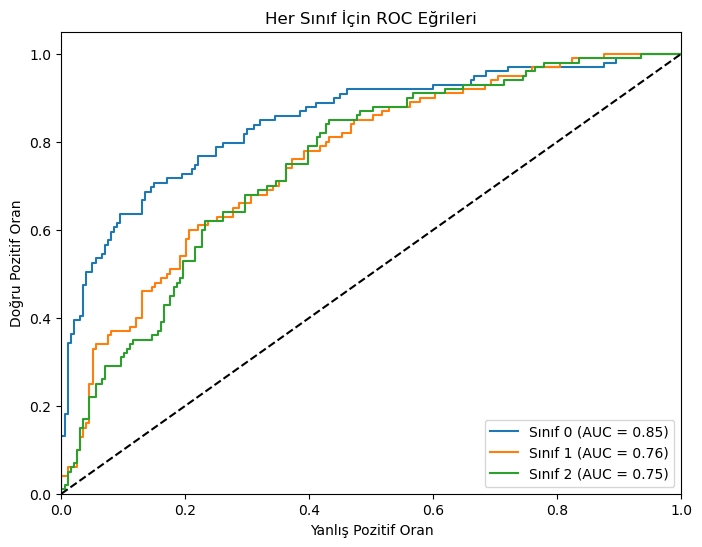

In [15]:
n_classes = len(np.unique(y_test))
y_score = grid_search.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Sınıf {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oran')
plt.ylabel('Doğru Pozitif Oran')
plt.title('Her Sınıf İçin ROC Eğrileri')
plt.legend(loc="lower right")
plt.show()

### **Zaman Serisi Çapraz Doğrulaması ile Model Değerlendirmesi**

Bu hücrede, `TimeSeriesSplit` kullanılarak veri setinde zaman bağımlılığını koruyan 5 katlı çapraz doğrulama yapılmış ve her katmanda modelin doğruluk skorları hesaplanmıştır.

#### **İşlem Adımları:**

1. **Zaman Serisi Çapraz Doğrulama:**  
   - `TimeSeriesSplit` ile veri 5 farklı parçaya ayrılır ve her seferinde belirli bir kısım eğitim, geri kalan kısım test için kullanılır.  
   - Zaman bağımlılığı korunduğu için önceki veriler eğitim setinde, sonraki veriler test setinde yer alır.

2. **Modelin Eğitilmesi ve Tahmin:**  
   - Her bir katmanda `grid_search` ile en iyi hiperparametrelerle model eğitilir ve test seti üzerinde tahmin yapılır.

3. **Doğruluk Skorlarının Hesaplanması:**  
   - Her katman için doğruluk (`accuracy`) skoru hesaplanır ve `ts_accuracy_scores` listesinde saklanır.

4. **Ortalama Doğruluk Skoru:**  
   - Tüm katmanlardaki doğruluk skorlarının ortalaması hesaplanır ve genel performans değerlendirilir.

#### **Amaç:**  
Zaman serisi verilerinde modelin farklı dönemlerdeki genel doğruluk performansını ölçmek ve overfitting (aşırı öğrenme) riskini değerlendirmek.


In [16]:
tscv = TimeSeriesSplit(n_splits=5)
ts_accuracy_scores = []

for train_index, test_index in tscv.split(X):
    X_train_ts, X_test_ts = X.iloc[train_index], X.iloc[test_index]
    y_train_ts, y_test_ts = y.iloc[train_index], y.iloc[test_index]
    
    grid_search.fit(X_train_ts, y_train_ts)
    y_pred_ts = grid_search.predict(X_test_ts)
    
    fold_accuracy = accuracy_score(y_test_ts, y_pred_ts)
    ts_accuracy_scores.append(fold_accuracy)
    print("Fold Accuracy: {:.4f}".format(fold_accuracy))

print("Zaman Serisi Split Ortalama Accuracy: {:.4f}".format(np.mean(ts_accuracy_scores)))

Fold Accuracy: 0.5484
Fold Accuracy: 0.6008
Fold Accuracy: 0.5645
Fold Accuracy: 0.6048
Fold Accuracy: 0.6331
Zaman Serisi Split Ortalama Accuracy: 0.5903


### **Enerji Verisinin Dosyadan Okunması ve Temizlenmesi**

Bu hücrede, enerji sektörüne ait aylık getiri verisi dosyadan okunmuş ve veri temizleme işlemleri gerçekleştirilmiştir.

#### **İşlem Adımları:**

1. **Verinin Okunması:**  
   - Enerji sektörüne ait aylık getiri verisi CSV dosyasından okunur ve tarih sütunu (`Date`) datetime formatına dönüştürülür.

2. **İlk Satırın Silinmesi:**  
   - 0. indeksteki satır boş olduğu için kaldırılır.

3. **Boş Değerlerin Temizlenmesi:**  
   - `Date` ve `Symbol` sütunlarında boş (NaN) değer bulunan satırlar silinir.

4. **Eksik Sayısal Değerlerin Doldurulması:**  
   - Sayısal sütunlardaki eksik değerler sütunun ortalama değeri ile doldurulur.

5. **Log Dönüşümlerinin Yapılması:**  
   - Fiyat verisi (`Price`) ve aylık getiri verisine (`Monthly Return`) log dönüşümü uygulanır:  
     - **`Log_Price`**: Fiyatın log dönüşümü.  
     - **`Log_Monthly_Return`**: Aylık getirinin log dönüşümü.  
   - Gerekli sütunlar yoksa hata mesajı ile uyarı verir.

#### **Amaç:**  
Enerji sektörüne ait ham veriyi eksik değerlerden arındırmak, log dönüşümleri uygulamak ve modelleme için uygun hale getirmek.


In [19]:
energy_csv = r'C:\Users\acer\Desktop\yzup\data\energy_aylik_donus.csv'
energy_df = pd.read_csv(energy_csv, parse_dates=['Date'])

energy_df = energy_df.drop(index=0)

energy_df = energy_df.dropna(subset=['Date', 'Symbol'])

numeric_cols = energy_df.select_dtypes(include='number').columns
energy_df[numeric_cols] = energy_df[numeric_cols].fillna(energy_df[numeric_cols].mean())

if 'Log_Price' not in energy_df.columns:
    if 'Price' in energy_df.columns:
        energy_df['Log_Price'] = np.log(energy_df['Price'] + 1)
    else:
        raise KeyError("Enerji CSV dosyasında 'Price' sütunu bulunamadı.")
        
if 'Log_Monthly_Return' not in energy_df.columns:
    if 'Monthly Return' in energy_df.columns:
        energy_df['Log_Monthly_Return'] = np.log(energy_df['Monthly Return'] + 1)
    else:
        raise KeyError("Enerji CSV dosyasında 'Monthly Return' sütunu bulunamadı.")

### **Rastgele Bir Hisse Senedi Seçimi**

Bu hücrede, enerji sektöründen rastgele bir hisse senedi seçilmiş ve o hisseye ait veriler filtrelenmiştir.

#### **İşlem Adımları:**

1. **Rastgele Hisse Seçimi:**  
   - Enerji sektörüne ait veri çerçevesinden (`energy_df`) benzersiz `Symbol` değerleri arasından rastgele bir hisse seçilir.

2. **Verilerin Filtrelenmesi:**  
   - Seçilen hisse senedine (`random_symbol`) ait tüm tarihsel veriler filtrelenerek ayrı bir veri çerçevesine (`energy_stock`) kaydedilir.

#### **Amaç:**  
Enerji sektöründen rastgele seçilen bir hisse senedi üzerinde öznitelik çıkarımı ve modelleme adımlarını uygulamaya hazırlık yapmak.


In [20]:
random_symbol = np.random.choice(energy_df['Symbol'].unique())
print(f"Rastgele seçilen enerji hissesinin sembolü: {random_symbol}")

energy_stock = energy_df[energy_df['Symbol'] == random_symbol].copy()

Rastgele seçilen enerji hissesinin sembolü: OXY


### **Pipeline’ın Beklediği Sütunların Hazırlanması**

Bu hücrede, enerji sektörü verisinin pipeline ile uyumlu hale getirilmesi için gerekli sütunlar oluşturulmuş ve seçilmiştir.

#### **İşlem Adımları:**

1. **Sektör Sütununun Eklenmesi:**  
   - Enerji verisine `Sector` sütunu eklenir ve tüm satırlara `'energy'` değeri atanır.

2. **Sektör Kodlamasının Eklenmesi:**  
   - Eğitimde kullanılan `LabelEncoder` enerji sektörünü encode etmediği için `Sector_Encoded` sütununa dummy (sahte) bir değer (`0`) atanır.  
   - Bu işlem, pipeline’ın sonraki adımlarında hata almamak için gereklidir.

3. **Gerekli Sütunların Seçilmesi:**  
   - Pipeline’ın beklediği şu sütunlar seçilerek işlenmiş veri çerçevesi (`energy_stock`) oluşturulur:  
     - `Symbol`  
     - `Date`  
     - `Log_Monthly_Return`  
     - `Log_Price`  
     - `Sector_Encoded`

#### **Amaç:**  
Veriyi pipeline ile uyumlu hale getirerek sonraki öznitelik çıkarma ve modelleme adımlarına hazırlık yapmak.


In [21]:
energy_stock['Sector'] = 'energy'

energy_stock['Sector_Encoded'] = 0

energy_stock = energy_stock[['Symbol', 'Date', 'Log_Monthly_Return', 'Log_Price', 'Sector_Encoded']]

### **TSFresh ile Öznitelik Çıkarımı**

Bu hücrede, daha önce tanımlanan pipeline’dan TSFresh öznitelik çıkarma adımı alınarak enerji sektörüne ait seçilen hissenin zaman serisi verilerinden istatistiksel özellikler çıkarılmıştır.

#### **İşlem Adımları:**

1. **TSFresh Adımının Alınması:**  
   - Tanımlanan pipeline’daki `tsfresh_feature_extraction` adımı alınır ve `energy_stock` verisine uygulanır.

2. **Özniteliklerin Çıkarılması:**  
   - `extract_features()` fonksiyonu, `Symbol`, `Date`, `Log_Monthly_Return` ve `Log_Price` sütunlarını kullanarak zaman serisinden çeşitli istatistiksel öznitelikler çıkarır (örneğin, ortalama, varyans, otokorelasyon).

3. **Sektör Bilgisinin Eklenmesi:**  
   - Öznitelikler çıkarıldıktan sonra her hisse senedine karşılık gelen `Sector_Encoded` bilgisi veri çerçevesine eklenir.

#### **Amaç:**  
Ham zaman serisi verilerinden istatistiksel ve anlamlı öznitelikler çıkararak bu özellikleri sınıflandırma modeli için kullanılabilir hale getirmek.


In [22]:
tsfresh_extractor = pipeline.named_steps['tsfresh_feature_extraction']
energy_features = tsfresh_extractor.transform(energy_stock)

Feature Extraction: 100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


### **Lasso ile Öznitelik Seçimi**

Bu hücrede, tanımlanan pipeline’ın `lasso_feature_selection` adımı kullanılarak enerji sektörüne ait seçilen hisse senedinin çıkarılmış özniteliklerinden en önemli olanları belirlenmiştir.

#### **İşlem Adımları:**

1. **Lasso Seçim Adımının Alınması:**  
   - Pipeline’daki `lasso_feature_selection` adımı alınır. Bu adım, daha önce `LassoCV` kullanılarak eğitim verisi üzerinde seçilen en önemli öznitelikleri belirler.

2. **Özniteliklerin Filtrelenmesi:**  
   - Çıkarılan tüm öznitelikler (`energy_features`) içerisinden Lasso tarafından sıfır olmayan katsayıya sahip özellikler seçilir.

3. **Sonuç:**  
   - Önemli öznitelikler (`energy_features_selected`) seçilir ve modelleme için uygun hale getirilir.

#### **Amaç:**  
L1 regularization ile gereksiz veya fazla bilgi içeren öznitelikleri eleyerek yalnızca modelin tahmin performansına en fazla katkıyı sağlayan özellikleri kullanmak.


In [23]:
lasso_selector = pipeline.named_steps['lasso_feature_selection']
energy_features_selected = lasso_selector.transform(energy_features)

### **Model için Girdi Matrisinin Oluşturulması ve Tahmin**

Bu hücrede, enerji sektörüne ait seçilen hissenin çıkarılmış ve filtrelenmiş öznitelikleri (`X_energy`) kullanılarak eğitimli model (RandomForest) ile sektör tahmini yapılmıştır.

#### **İşlem Adımları:**

1. **Girdi Matrisinin Oluşturulması:**  
   - Seçilen özniteliklerden oluşan veri çerçevesinden hedef sütunu (`Sector_Encoded`) çıkarılır ve modelin tahmin yapması için girdi matrisi (`X_energy`) hazırlanır.

2. **Tahmin:**  
   - Daha önce en iyi hiperparametrelerle eğitilmiş RandomForest modeli (`grid_search`) kullanılarak enerji sektörüne ait hisse senedinin hangi sektöre benzediği tahmin edilir.

#### **Sonuç:**  
Tahmin edilen sınıf (`predicted_class`) bir sonraki adımda gerçek sektör etiketi ile eşleştirilerek sonuç yorumlanır.

#### **Amaç:**  
Çıkarılan ve seçilen öznitelikleri kullanarak seçilen enerji hissesinin hangi sektöre daha çok benzediğini belirlemek.


In [24]:
X_energy = energy_features_selected.drop(columns=['Sector_Encoded'])

predicted_class = grid_search.predict(X_energy)[0]

### **Tahmin Edilen Sınıfın Orijinal Sektör Etiketine Dönüştürülmesi**

Bu hücrede, RandomForest modeli ile tahmin edilen sayısal sınıf (`predicted_class`), orijinal sektör etiketine çevrilmiştir.

#### **İşlem Adımları:**

1. **Label Encoder’ın Alınması:**  
   - Pipeline’daki `label_encoding_feature_selection` adımında fit edilen `LabelEncoder` alınır ve sektör etiketlerini dönüştürmek için kullanılır.

2. **Sınıfın Dönüştürülmesi:**  
   - Tahmin edilen sayısal sınıf (`predicted_class`), `inverse_transform` metodu ile orijinal sektör ismine dönüştürülür.

3. **Sonuç:**  
   - Tahmin edilen sektör etiketi (`predicted_sector`) ekrana yazdırılır.

#### **Amaç:**  
Modelin tahmin ettiği sayısal sınıfın anlamlı bir şekilde yorumlanmasını sağlamak ve hangi sektöre daha çok benzediğini belirlemek.


In [25]:
sector_encoder = pipeline.named_steps['label_encoding_feature_selection'].label_encoder_sector
predicted_sector = sector_encoder.inverse_transform([predicted_class])[0]

print(f"\nSeçilen enerji hissesinin tahminen en çok benzediği sektör: {predicted_sector}")


Seçilen enerji hissesinin tahminen en çok benzediği sektör: financials


### **Tahmin Olasılıklarının Yüzdelik Dağılımı (Sektörel Benzerlik)**

Bu hücrede, RandomForest modelinin tahmin ettiği olasılık dağılımı hesaplanmış ve her sektör için benzerlik yüzdeleri yazdırılmıştır.

#### **İşlem Adımları:**

1. **Olasılıkların Hesaplanması:**  
   - `predict_proba` metodu kullanılarak enerji hissesinin her sektörle olan benzerlik olasılıkları hesaplanır.

2. **Sınıf Etiketlerinin Dönüştürülmesi:**  
   - Sayısal sınıf etiketleri (`classes`) `inverse_transform` ile orijinal sektör isimlerine dönüştürülür.

3. **Olasılıkların Yazdırılması:**  
   - Her sektör için tahmin edilen olasılık yüzdesi hesaplanır ve yazdırılır.

#### **Sonuç:**  
Model, enerji sektöründeki bu hissenin farklı sektörlerle olan benzerlik yüzdelerini verir. Bu bilgiler, portföy yönetimi ve yatırım stratejileri için değerlendirilebilir.

#### **Amaç:**  
Hisse senedinin hangi sektörle ne derece benzerlik gösterdiğini anlamak ve sektörel benzerlik analizini detaylandırmak.


In [26]:
predicted_proba = grid_search.predict_proba(X_energy)[0]

classes = grid_search.classes_
sectors = sector_encoder.inverse_transform(classes)

print("\nTahmin Olasılıkları (Sektör Benzerlik Yüzdeleri):")
for sector, proba in zip(sectors, predicted_proba):
    print(f"{sector}: {proba * 100:.2f}%")


Tahmin Olasılıkları (Sektör Benzerlik Yüzdeleri):
financials: 78.60%
healthcare: 8.60%
technology: 12.80%


### **Benzerlik Matrisinin Isı Haritasını Çizme**

Bu hücrede, enerji hissesinin diğer sektörlerle olan benzerlik yüzdelerini gösteren bir ısı haritası oluşturulmuştur.

#### **Sonuç:**  
Isı haritası, enerji hissesinin diğer sektörlere hangi ölçüde benzediğini görsel olarak sunar ve sektörel benzerlik analizini daha anlaşılır hale getirir.

#### **Amaç:**  
Benzerlik yüzdelerinin görselleştirilmesiyle yatırımcıların karar alma sürecini kolaylaştırmak.

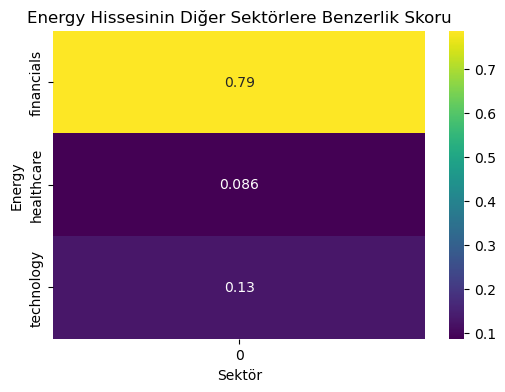

In [27]:
similarity_series = pd.Series(predicted_proba, index=sectors)

plt.figure(figsize=(6, 4))
sns.heatmap(similarity_series.to_frame(), annot=True, cmap='viridis')
plt.title("Energy Hissesinin Diğer Sektörlere Benzerlik Skoru")
plt.xlabel("Sektör")
plt.ylabel("Energy")
plt.show()

### **Farklı Sektörlerin Hisse Senedi Davranışlarını Açıklayan Analiz Raporu**

Bu hücrede, farklı sektörlere ait hisse senetlerinin fiyat ve aylık getiri verileri üzerinden temel istatistiksel analiz yapılmıştır. Veriler, farklı sektörlerdeki hisse senetlerinin davranışlarını ve performans dinamiklerini anlamaya yöneliktir.

#### **Sonuç:**  
Bu analiz, sektörlerin genel performansını karşılaştırmak ve risk düzeylerini belirlemek için kullanılabilir. Sektörlerin fiyat ve getiri dinamikleri, yatırım stratejilerini şekillendirmek için önemli ipuçları sunar.

#### **Amaç:**  
Farklı sektörlerdeki hisse senetlerinin performans dinamiklerini analiz ederek yatırım kararları ve portföy çeşitlendirme stratejileri için bir temel oluşturmaktır.


In [28]:
try:
    all_sectors_df
except NameError:
    np.random.seed(42)
    sectors = ['financials', 'healthcare', 'technology', 'energy']
    dates = pd.date_range(start='2020-01-01', periods=24, freq='M')
    records = []
    for sector in sectors:
        for i in range(10): 
            symbol = f"{sector[:3].upper()}{i}"
            for date in dates:
                price = np.random.lognormal(mean=3, sigma=0.2)
                monthly_return = np.random.normal(loc=0.01, scale=0.05)
                records.append({
                    'Symbol': symbol,
                    'Date': date,
                    'Price': price,
                    'Monthly Return': monthly_return,
                    'Sector': sector
                })
    all_sectors_df = pd.DataFrame(records)
    
    all_sectors_df['Log_Price'] = np.log(all_sectors_df['Price'] + 1)
   
    min_return = all_sectors_df['Monthly Return'].min()
    all_sectors_df['Log_Monthly_Return'] = np.log(all_sectors_df['Monthly Return'] - min_return + 0.001)

sector_stats = all_sectors_df.groupby('Sector').agg({
    'Price': ['mean', 'std'],
    'Monthly Return': ['mean', 'std']
}).reset_index()
sector_stats.columns = ['Sector', 'Avg_Price', 'Std_Price', 'Avg_Monthly_Return', 'Std_Monthly_Return']

print("\nGenel Sektör İstatistikleri:")
print(sector_stats)


Genel Sektör İstatistikleri:
       Sector  Avg_Price  Std_Price  Avg_Monthly_Return  Std_Monthly_Return
0      energy  20.450746   3.832175            0.014735            0.051088
1  financials  20.530135   4.167681            0.011158            0.048228
2  healthcare  20.444135   3.939888            0.013058            0.050099
3  technology  20.929481   3.937040            0.011373            0.053752


### **Farklı Sektörlerin Fiyat Dağılımlarının Görselleştirilmesi**

Bu hücrede, farklı sektörlerdeki belirli fiyat dağılımları bir kutu grafiği (boxplot) ile görselleştirilmiştir. Bu görselleştirme, her sektördeki fiyatların dağılımını ve olası uç değerleri analiz etmeye olanak tanır.

#### **Sonuç:**  
Bu grafik, her sektördeki fiyat varyasyonlarını ve olası uç değerleri gözlemlemeyi sağlar. Sektörler arasında fiyatların nasıl farklılaştığını incelemek ve hangi sektörlerin daha volatil olduğunu anlamak için kullanılabilir.


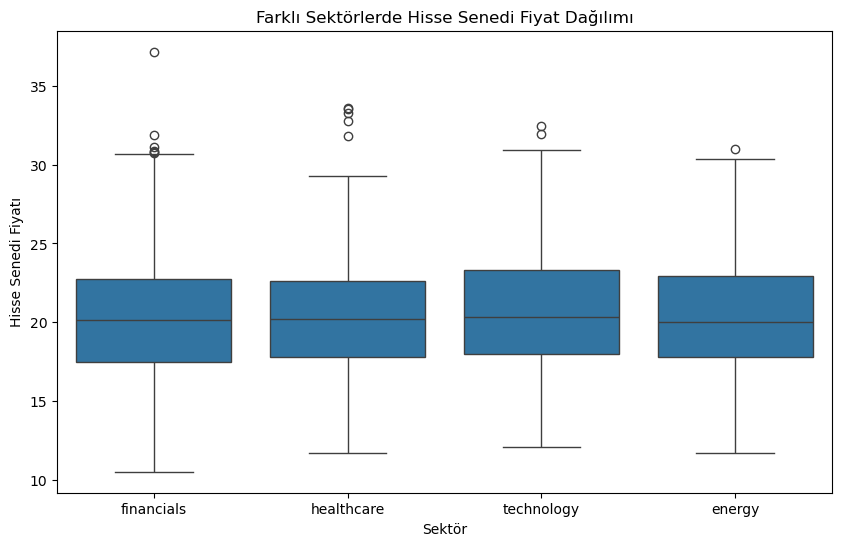

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sector', y='Price', data=all_sectors_df)
plt.title("Farklı Sektörlerde Hisse Senedi Fiyat Dağılımı")
plt.xlabel("Sektör")
plt.ylabel("Hisse Senedi Fiyatı")
plt.show()

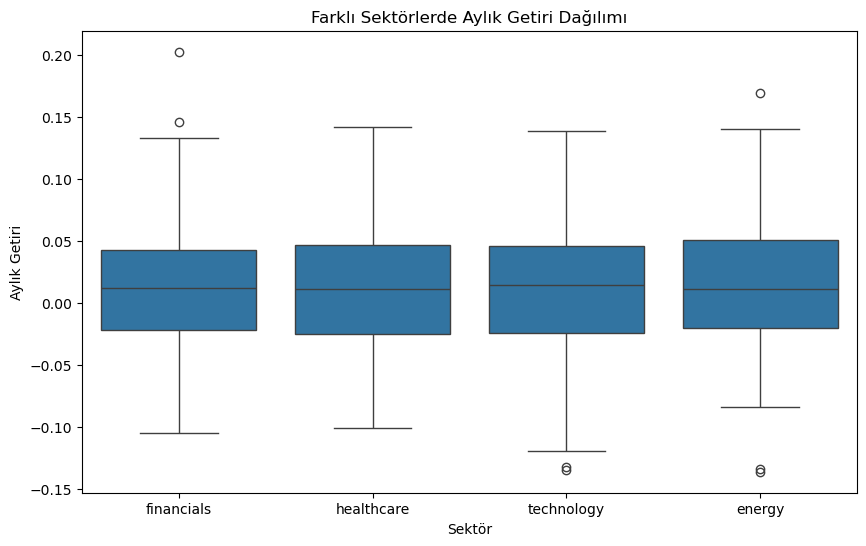

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sector', y='Monthly Return', data=all_sectors_df)
plt.title("Farklı Sektörlerde Aylık Getiri Dağılımı")
plt.xlabel("Sektör")
plt.ylabel("Aylık Getiri")
plt.show()

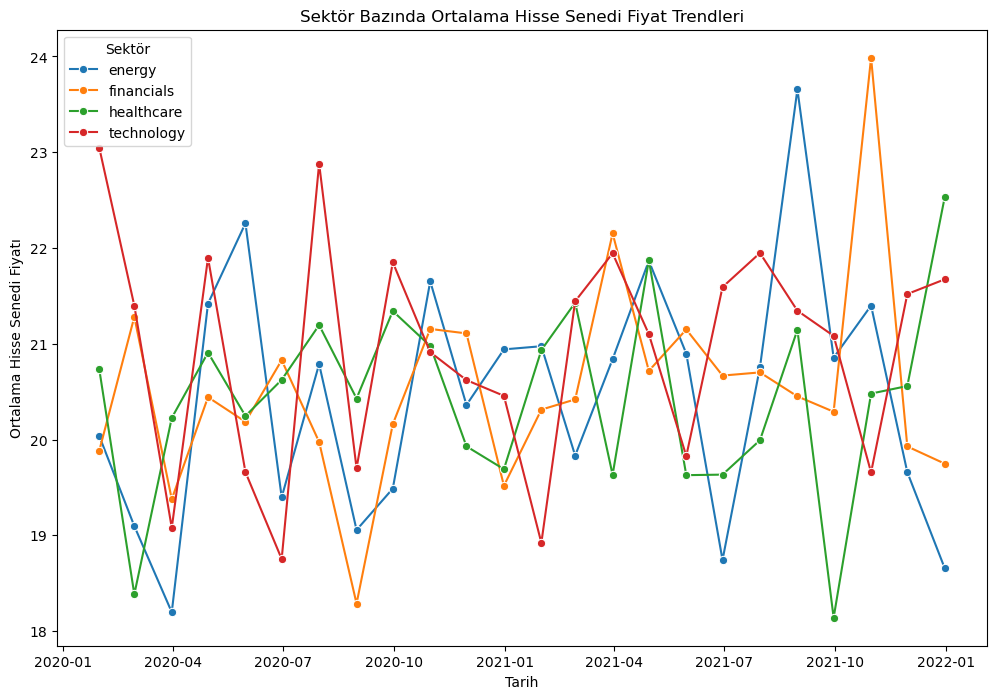

In [31]:
avg_price_trend = all_sectors_df.groupby(['Sector', 'Date'])['Price'].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.lineplot(x='Date', y='Price', hue='Sector', data=avg_price_trend, marker='o')
plt.title("Sektör Bazında Ortalama Hisse Senedi Fiyat Trendleri")
plt.xlabel("Tarih")
plt.ylabel("Ortalama Hisse Senedi Fiyatı")
plt.legend(title="Sektör")
plt.show()

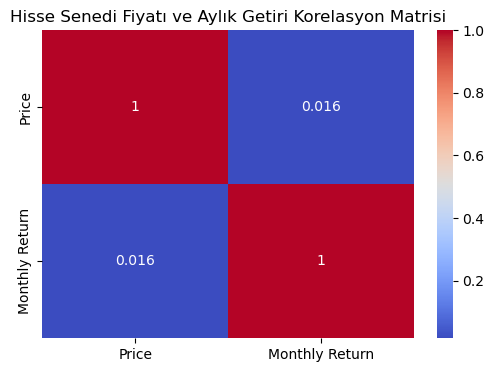

In [32]:
correlation_matrix = all_sectors_df[['Price', 'Monthly Return']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Hisse Senedi Fiyatı ve Aylık Getiri Korelasyon Matrisi")
plt.show()

### **Sektörel Benzerlik Analizi ve Yatırım Stratejileri Önerileri**

Bu hücrede, modelin enerji sektörüne ait seçilen hisse için belirlediği sektörel benzerlik yüzdeleri analiz edilmiş ve bu bilgiler ışığında yatırım stratejileri önerilmiştir.

#### **Sonuç:**  
- **En Yüksek Benzerlik Gösteren Sektör:** Modelin enerji hissesinin en çok benzediği sektör.  
- **İkinci En Yüksek Benzerlik:** Portföyde değerlendirilebilecek alternatif sektör.

#### **Öneriler:**  
1. Eğer enerji hissesinin en çok benzediği sektör yüksek benzerlik oranına sahipse, bu sektörün trendleri yakından takip edilmelidir.  
2. Orta veya düşük benzerlik oranları durumunda, portföy çeşitlendirilerek farklı sektörlerdeki potansiyeller de değerlendirilmelidir.

#### **Amaç:**  
Sektörel benzerlik analizini yatırım kararlarına dönüştürerek portföy yönetiminde daha bilinçli ve stratejik adımlar atılmasını sağlamak. Grafik, enerji hissesinin en çok benzediği sektörleri sıralı bir şekilde görmemizi sağlar.



Sektörel Benzerlik Yüzdelerine Göre Sıralama:
       Sector  Similarity_Percentage
0  financials                   78.6
1  technology                   12.8
2  healthcare                    8.6

Yatırım Stratejileri Önerileri:
1. En yüksek benzerlik: financials (%78.60).
   - Bu yüksek benzerlik oranı, portföyünüzde bu sektörün trendlerini yakından takip etmeniz gerektiğini göstermektedir.
2. İkinci en yüksek benzerlik: technology (%12.80).
   - Bu sektör de yatırım stratejilerinizde değerlendirilmesi gereken önemli bir faktör olabilir.


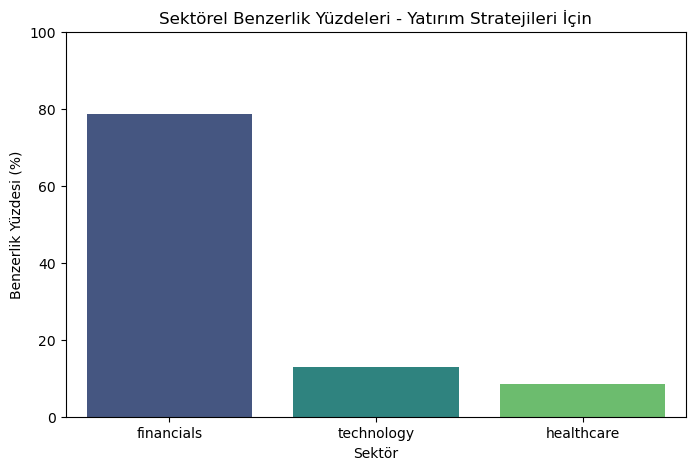

In [33]:
model_sectors = sector_encoder.inverse_transform(grid_search.classes_)

investment_df = pd.DataFrame({
    'Sector': model_sectors,
    'Similarity_Percentage': predicted_proba * 100  # yüzde olarak ifade edelim
})

investment_df = investment_df.sort_values(by='Similarity_Percentage', ascending=False).reset_index(drop=True)
print("\nSektörel Benzerlik Yüzdelerine Göre Sıralama:")
print(investment_df)

print("\nYatırım Stratejileri Önerileri:")
top_sector = investment_df.loc[0, 'Sector']
top_similarity = investment_df.loc[0, 'Similarity_Percentage']
print(f"1. En yüksek benzerlik: {top_sector} (%{top_similarity:.2f}).")
if top_similarity > 50:
    print("   - Bu yüksek benzerlik oranı, portföyünüzde bu sektörün trendlerini yakından takip etmeniz gerektiğini göstermektedir.")
else:
    print("   - Benzerlik oranı orta seviyede; portföyünüzde çeşitlendirmeyi sürdürürken bu sektörü de göz önünde bulundurabilirsiniz.")

if len(investment_df) > 1:
    second_sector = investment_df.loc[1, 'Sector']
    second_similarity = investment_df.loc[1, 'Similarity_Percentage']
    print(f"2. İkinci en yüksek benzerlik: {second_sector} (%{second_similarity:.2f}).")
    print("   - Bu sektör de yatırım stratejilerinizde değerlendirilmesi gereken önemli bir faktör olabilir.")

plt.figure(figsize=(8, 5))
sns.barplot(x='Sector', y='Similarity_Percentage', data=investment_df, palette='viridis')
plt.title("Sektörel Benzerlik Yüzdeleri - Yatırım Stratejileri İçin")
plt.xlabel("Sektör")
plt.ylabel("Benzerlik Yüzdesi (%)")
plt.ylim(0, 100)
plt.show()

### **Eğittiğimiz sektörlerden (teknoloji, sağlık ve finans) birini seçerek doğruluk testi yapıyoruz**
#### Buradaki amacımız, örneğin finans sektörünü seçtiğimizde, tahminlerin en az %80’inin finans olarak sınıflandırılmasıdır.

In [7]:
testt_csv = r'C:\Users\acer\Desktop\yzup\data\financials_aylik_donus.csv'
testt_df = pd.read_csv(testt_csv, parse_dates=['Date'])

testt_df = testt_df.drop(index=0)
testt_df = testt_df.dropna(subset=['Date', 'Symbol'])

numeric_cols = testt_df.select_dtypes(include='number').columns
testt_df[numeric_cols] = testt_df[numeric_cols].fillna(testt_df[numeric_cols].mean())

if 'Log_Price' not in testt_df.columns:
    if 'Price' in testt_df.columns:
        testt_df['Log_Price'] = np.log(testt_df['Price'] + 1)
    else:
        raise KeyError("Testt CSV dosyasında 'Price' sütunu bulunamadı.")
        
if 'Log_Monthly_Return' not in testt_df.columns:
    if 'Monthly Return' in testt_df.columns:
        testt_df['Log_Monthly_Return'] = np.log(testt_df['Monthly Return'] + 1)
    else:
        raise KeyError("Testt CSV dosyasında 'Monthly Return' sütunu bulunamadı.")

random_symbol = np.random.choice(testt_df['Symbol'].unique())
print(f"Rastgele seçilen testt hissesinin sembolü: {random_symbol}")

testt_stock = testt_df[testt_df['Symbol'] == random_symbol].copy()

testt_stock['Sector'] = 'testt'
testt_stock['Sector_Encoded'] = 0
testt_stock = testt_stock[['Symbol', 'Date', 'Log_Monthly_Return', 'Log_Price', 'Sector_Encoded']]

tsfresh_extractor = pipeline.named_steps['tsfresh_feature_extraction']
testt_features = tsfresh_extractor.transform(testt_stock)

lasso_selector = pipeline.named_steps['lasso_feature_selection']
testt_features_selected = lasso_selector.transform(testt_features)

X_testt = testt_features_selected.drop(columns=['Sector_Encoded'])

predicted_class = grid_search.predict(X_testt)[0]

sector_encoder = pipeline.named_steps['label_encoding_feature_selection'].label_encoder_sector
predicted_sector = sector_encoder.inverse_transform([predicted_class])[0]

print(f"\nSeçilen testt hissesinin tahminen en çok benzediği sektör: {predicted_sector}")

predicted_proba = grid_search.predict_proba(X_testt)[0]

classes = grid_search.classes_
sectors = sector_encoder.inverse_transform(classes)

print("\nTahmin Olasılıkları (Sektör Benzerlik Yüzdeleri):")
for sector, proba in zip(sectors, predicted_proba):
    print(f"{sector}: {proba * 100:.2f}%")

Rastgele seçilen testt hissesinin sembolü: BOKF


Feature Extraction: 100%|██████████| 2/2 [00:07<00:00,  3.84s/it]



Seçilen testt hissesinin tahminen en çok benzediği sektör: financials

Tahmin Olasılıkları (Sektör Benzerlik Yüzdeleri):
financials: 95.30%
healthcare: 2.58%
technology: 2.11%


### **Öznitelik seçiminde ComprehensiveFCParameters() parametresini deniyoruz (Daha yüksek doğruluk verir fakat daha uzun sürer)**

In [5]:
# --------------- DATA LOADING & CLEANING TRANSFORMER ---------------
class DataLoaderCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, sectors_and_files):
        self.sectors_and_files = sectors_and_files

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        combined_df_list = []
        for sector, file_path in self.sectors_and_files.items():
            df = pd.read_csv(file_path, parse_dates=['Date'])
            df = df.drop(index=0) 
            df = df.dropna(subset=['Date', 'Symbol'])  
            df['Sector'] = sector 
            combined_df_list.append(df)
        combined_df = pd.concat(combined_df_list, ignore_index=True)
       
        numeric_cols = combined_df.select_dtypes(include='number').columns
        combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].mean())
     
        combined_df['Log_Price'] = np.log(combined_df['Price'] + 1)
        combined_df['Log_Monthly_Return'] = np.log(combined_df['Monthly Return'] + 1)
       
        combined_df['Log_Monthly_Return'].replace(-np.inf, np.nan, inplace=True)
        combined_df['Log_Monthly_Return'].fillna(0, inplace=True)
        return combined_df

# --------------- LABEL ENCODING & FEATURE SELECTION TRANSFORMER ---------------
class LabelEncodingFeatureSelection(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.label_encoder_sector = LabelEncoder().fit(X['Sector'])
        self.label_encoder_symbol = LabelEncoder().fit(X['Symbol'])
        return self

    def transform(self, X):
        X = X.copy()
        X['Sector_Encoded'] = self.label_encoder_sector.transform(X['Sector'])
        X['Symbol_Encoded'] = self.label_encoder_symbol.transform(X['Symbol'])
        return X[['Symbol', 'Date', 'Log_Monthly_Return', 'Log_Price', 'Sector_Encoded']]

# --------------- TSFRESH FEATURE EXTRACTION TRANSFORMER ---------------
class TSFreshFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_jobs_value):
        self.fc_parameters = ComprehensiveFCParameters()  
        self.n_jobs_value = n_jobs_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_filtered = X[['Symbol', 'Date', 'Log_Monthly_Return', 'Log_Price']]
        features = extract_features(
            df_filtered,
            column_id='Symbol',
            column_sort='Date',
            default_fc_parameters=self.fc_parameters,
            n_jobs=self.n_jobs_value
        )
      
        features.replace([np.inf, -np.inf], np.nan, inplace=True)
        features.fillna(0, inplace=True)
       
        features = features.join(
            X[['Symbol', 'Sector_Encoded']].drop_duplicates().set_index('Symbol')
        )
        return features

# --------------- LASSO FEATURE SELECTOR ---------------
class LassoFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_features = None

    def fit(self, X, y=None):
        if y is None:
            y = X['Sector_Encoded']
        
        X_filtered = X.filter(regex='^(Log_Monthly_Return|Log_Price)__')
      
        X_filtered = X_filtered.replace([np.inf, -np.inf], np.nan).fillna(0)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_filtered)
        lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)
        self.selected_features = X_filtered.columns[lasso.coef_ != 0]
        return self

    def transform(self, X):
        return X[self.selected_features.tolist() + ['Sector_Encoded']]

# --------------- PIPELINE TANIMLAMASI ---------------
pipeline = Pipeline([
    ('data_loading_cleaning', DataLoaderCleaner(sectors_and_files={
        'financials': r'C:\Users\acer\Desktop\yzup\data\financials_aylik_donus.csv',
        'healthcare': r'C:\Users\acer\Desktop\yzup\data\healthcare_aylik_donus.csv',
        'technology': r'C:\Users\acer\Desktop\yzup\data\technology_aylik_donus.csv'
    })),
    ('label_encoding_feature_selection', LabelEncodingFeatureSelection()),
    ('tsfresh_feature_extraction', TSFreshFeatureExtractor(n_jobs_value=max(1, os.cpu_count() - 1))),
    ('lasso_feature_selection', LassoFeatureSelector())
])


processed_data = pipeline.fit_transform(None, None)


X = processed_data.drop(columns=['Sector_Encoded'])
y = processed_data['Sector_Encoded']

# --- Sonsuz ve çok büyük değerlerin kontrolü ---
X = X.replace([np.inf, -np.inf], np.nan)
X = np.nan_to_num(X, nan=0.0, posinf=1e5, neginf=-1e5)

# --------------- RANDOM FOREST MODEL İÇİN HİPERPARAMETRE OPTİMİZASYONU ---------------
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=max(1, os.cpu_count() - 1)
)

grid_search.fit(X, y)

print("\nEn iyi hiperparametreler:")
print(grid_search.best_params_)
print(f"En iyi modelin cross-validation doğruluğu: {grid_search.best_score_:.4f}")


Feature Extraction: 100%|██████████| 35/35 [04:30<00:00,  7.72s/it]



En iyi hiperparametreler:
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
En iyi modelin cross-validation doğruluğu: 0.6754
